In [1]:
import os
import json
import copy
import torch
import base64
from PIL import Image
from io import BytesIO
from qwen_vl_utils import extract_vision_info
from transformers import AutoConfig, AutoTokenizer, AutoProcessor
from qwen_vl.model.vggt.utils.load_fn import load_and_preprocess_images
from qwen_vl.model.modeling_qwen2_5_vl import Qwen2_5_VLForConditionalGenerationWithVGGT

In [2]:
# hyperparameters inherited from Qwen2.5-VL
min_pixels: int = 256 * 28 * 28
max_pixels: int = 1605632
max_num_frames: int = 32

# others
device="cuda:0"
demo_data_dir = "data/demo_data"

## The Inference Interface for VG LLM

In [3]:
class VGLLM_Inference:
    def __init__(self, pretrained):
        # load the model
        config = AutoConfig.from_pretrained(pretrained)
        self.model = Qwen2_5_VLForConditionalGenerationWithVGGT.from_pretrained(
            pretrained,
            config=config,
            torch_dtype=torch.bfloat16,
            device_map=device,
            attn_implementation="flash_attention_2",
        ).eval()
        
        # load the tokenizer
        self.tokenizer = AutoTokenizer.from_pretrained(pretrained, padding_side="left")
        
        # load the tokenizer
        self.processor = AutoProcessor.from_pretrained(pretrained, max_pixels=max_pixels, min_pixels=min_pixels, padding_side="left")

    def call_model(
        self,
        contexts,
        visuals,
        add_frame_index: bool=False,
        gen_kwargs: dict = {},
    ):
        res = []
        messages = []
        processed_visuals = []
        for i, context in enumerate(contexts):
    
            message = [{"role": "system", "content": "You are a helpful assistant."}]
    
            if len(visuals) > 0:
                visual = visuals[i] if i < len(visuals) else None
                if isinstance(visual, str) and visual.endswith((".mp4", ".avi", ".mov")):  # Video file
                    vr = decord.VideoReader(visual)
                    image_num = len(vr)
                    # sample max_num_frames frame indices from the video
                    if image_num < self.max_num_frames:
                        frame_indices = np.arange(image_num)
                    else:
                        frame_indices = np.linspace(0, image_num - 1, self.max_num_frames).astype(int)
                    # read the frames
                    frames = [vr[i].asnumpy() for i in frame_indices]
                    visual_content = []
                    for frame in frames:
                        image = Image.fromarray(frame).convert("RGB")
                        visual_content.append({"type": "image", "image": image})
                        visual_content.append({"type": "text", "text": "\n"})
                    message.append({"role": "user", "content": visual_content + [{"type": "text", "text": context}]})
    
                elif isinstance(visual, Image.Image):  # Single image
                    base64_image = visual.convert("RGB")
                    buffer = BytesIO()
                    base64_image.save(buffer, format="JPEG")
                    base64_bytes = base64.b64encode(buffer.getvalue())
                    base64_string = base64_bytes.decode("utf-8")
                    message.append({"role": "user", "content": [{"type": "image", "image": f"data:image/jpeg;base64,{base64_string}"}, {"type": "text", "text": context}]})
                elif isinstance(visual, (list, tuple)) and all(isinstance(v, Image.Image) for v in visual):  # Multiple images
                    image_content = []
                    image_count = 0
                    for v in visual:
                        base64_image = v.convert("RGB")
                        buffer = BytesIO()
                        base64_image.save(buffer, format="JPEG")
                        base64_bytes = base64.b64encode(buffer.getvalue())
                        base64_string = base64_bytes.decode("utf-8")
                        if add_frame_index:
                            image_content.append({"type": "text", "text": "Frame-{}: ".format(image_count)})    
                        image_content.append({"type": "image", "image": f"data:image/jpeg;base64,{base64_string}"})
                        image_count += 1
                    message.append({"role": "user", "content": image_content + [{"type": "text", "text": context}]})
                else:
                    message.append({"role": "user", "content": [{"type": "text", "text": context}]})
            else:
                message.append({"role": "user", "content": [{"type": "text", "text": context}]})
    
            messages.append(message)
    
        text = self.processor.apply_chat_template(messages, tokenize=False, add_generation_prompt=True)
        # image_inputs, video_inputs = process_vision_info(messages)
    
        images_vggt = []
        image_inputs = []
        patch_size = self.processor.image_processor.patch_size
        merge_size = self.processor.image_processor.merge_size
        for message in messages:
            vision_info = extract_vision_info(message)
            cur_images_vggt = []
            for ele in vision_info:
                if "image" in ele:
                    image = ele["image"]
                    if isinstance(image, Image.Image):
                        pass
                    elif isinstance(image, str) and "base64," in image:
                        _, base64_data = image.split("base64,", 1)
                        data = base64.b64decode(base64_data)
                        # fix memory leak issue while using BytesIO
                        with BytesIO(data) as bio:
                            image = copy.deepcopy(Image.open(bio))
                    else:
                        raise NotImplementedError("Unsupported image type")
    
                else:
                    raise NotImplementedError("Unsupported vision info type")
    
                assert isinstance(image, Image.Image), f"Unsupported image type: {type(image)}"
                image = load_and_preprocess_images([image])[0]
                cur_images_vggt.append(copy.deepcopy(image))
                _, height, width = image.shape
                # merge_size = 2
                if (width // patch_size) % merge_size > 0:
                    width = width - (width // patch_size) % merge_size * patch_size
                if (height // patch_size) % merge_size > 0:
                    height = height - (height // patch_size) % merge_size * patch_size
                image = image[:, :height, :width]
                image_inputs.append(image)
    
            images_vggt.append(torch.stack(cur_images_vggt))
        inputs = self.processor(
            text=text,
            images=image_inputs,
            videos=None,
            padding=True,
            return_tensors="pt",
            do_rescale=False
        )
        device = self.model.device
        if getattr(self.model.config, "use_vggt_feature", False):
            inputs["images_vggt"] = [feat.to(device) for feat in images_vggt]
        inputs = inputs.to(device)
    
        if "max_new_tokens" not in gen_kwargs:
            gen_kwargs["max_new_tokens"] = 4096
        if "temperature" not in gen_kwargs:
            gen_kwargs["temperature"] = 0
        if "top_p" not in gen_kwargs:
            gen_kwargs["top_p"] = None
        if "num_beams" not in gen_kwargs:
            gen_kwargs["num_beams"] = 1
    
        pad_token_id = self.tokenizer.pad_token_id
    
        cont = self.model.generate(
            **inputs,
            eos_token_id=self.tokenizer.eos_token_id,
            pad_token_id=pad_token_id,
            do_sample=True if gen_kwargs["temperature"] > 0 else False,
            temperature=gen_kwargs["temperature"],
            top_p=gen_kwargs["top_p"],
            num_beams=gen_kwargs["num_beams"],
            max_new_tokens=gen_kwargs["max_new_tokens"],
        )
    
        generated_ids_trimmed = [out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, cont)]
        answers = self.processor.batch_decode(generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False)
        for i, ans in enumerate(answers):
            answers[i] = ans
    
        for ans, context in zip(answers, contexts):
            res.append(ans)
    
        return res


## Examples for 3D Video Object Detection

In [4]:
pretrained = "./data/model/VGLLM_for_3D_Scene_Understanding_4B"

model = VGLLM_Inference(pretrained)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.50, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


In [5]:
# load data
task = "3d_video_object_detection"
with open(os.path.join(demo_data_dir, task, "samples.json"))as f:
    data = json.load(f)

print(f"{len(data)} items loaded")

media_dir = os.path.join(demo_data_dir, task, "media")

10 items loaded


In [6]:
# visualization
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R
from visualize_tools.img_drawer import ImageDrawer
from visualize_tools.color_selector import ColorMap

color_selctor = ColorMap()

def visualize_3d_video_object_detection(sample, prediction):
    try:
        prediction = prediction.strip('\n').strip("```").strip("json").strip()
        bbox_list = eval(prediction)
    except Exception as e:
        print(e)
        return

    images = sample["images"]
    np_images = []
    for i, img in enumerate(images):
        drawer = ImageDrawer(os.path.join(media_dir, img))
        for item in bbox_list:
            if isinstance(item["bbox_3d"], str):
                item["bbox_3d"] = eval(item["bbox_3d"])
            center = np.array(item["bbox_3d"][:3]).reshape(3, 1)
            extent = np.array(item["bbox_3d"][3:6]).reshape(3, 1)
            rot = R.from_euler('zxy', np.array(item["bbox_3d"][6:9])).as_matrix() 
            geo = o3d.geometry.OrientedBoundingBox(center, rot, extent)
            intrinsic = np.array([[1170.18798828125, 0.0, 647.75, 0.0], [0.0, 1170.18798828125, 483.75, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
            extrinsic = np.linalg.inv(np.array(sample["cam2global"][0])) @ np.array(sample["cam2global"][i])
            try:
                color = color_selctor.get_color(item["label"])
            except:
                color = (0, 255, 0)
    
            drawer.draw_box3d(
                geo,
                color, 
                item["label"], 
                extrinsic, 
                intrinsic,
            )
        np_images.append(copy.deepcopy(drawer.img / 255.0))

    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(10, 6))
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        if i < len(images):
            ax.imshow(np_images[i])
            ax.set_title(f'Image {i}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
        
            

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


/home/zhengduo/miniconda3/envs/vgllm2/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:628: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(
/home/zhengduo/workspace/vgllm/src/qwen_vl/model/modeling_qwen2_5_vl.py:1990: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast(dtype=dtype):


Output: ```json
[
	{"label": "toilet paper", "bbox_3d": [-0.46, 1.25, 1.07, 0.11, 0.15, 0.12, 2.89, 1.53, -2.5]},
	{"label": "picture", "bbox_3d": [-0.22, 0.06, 1.26, 0.05, 0.43, 0.53, 2.89, 1.53, -2.5]},
	{"label": "towel", "bbox_3d": [0.62, 1.42, 0.61, 0.48, 0.84, 0.11, 2.89, 1.53, -2.5]},
	{"label": "curtain", "bbox_3d": [0.43, 0.36, 1.2, 0.35, 0.3, 1.92, 2.89, 1.53, -2.5]},
	{"label": "bathtub", "bbox_3d": [0.96, 1.25, 0.81, 0.76, 1.45, 0.37, -0.25, 1.53, -2.5]},
	{"label": "toilet", "bbox_3d": [-0.01, 1.11, 1.03, 0.75, 0.45, 0.87, 2.89, 1.53, -2.5]},
	{"label": "bin", "bbox_3d": [-0.42, 1.35, 1.15, 0.15, 0.33, 0.34, 2.89, 1.53, -2.5]}
]```


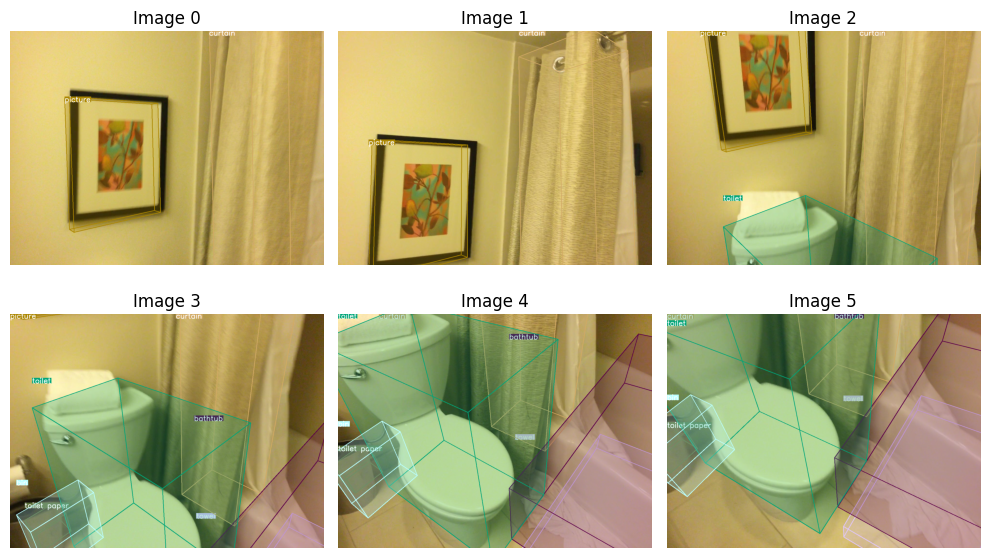

In [7]:
def process_3d_video_object_detection(sample):
    text = sample["conversations"][0]["value"].replace("<image>", "")
    image_files = sample["images"]
    images = [
        Image.open(
            os.path.join(demo_data_dir, f"{task}/media", image_file)
        ).convert("RGB")
        for image_file in image_files
    ]

    output = model.call_model(
        contexts=[text],
        visuals=[images],
    )[0]

    print("Output:", output)
    visualize_3d_video_object_detection(sample, output)

process_3d_video_object_detection(data[0])

## Examples for 3d Visual Grounding

In [8]:
# load data
task = "3d_visual_grounding"
with open(os.path.join(demo_data_dir, task, "samples.json"))as f:
    data = json.load(f)

print(f"{len(data)} items loaded")

media_dir = os.path.join(demo_data_dir, task, "media")

10 items loaded


In [9]:
# visualization
import open3d as o3d
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.transform import Rotation as R
from visualize_tools.img_drawer import ImageDrawer

def visualize_3d_visual_grounding(sample, prediction):
    try:
        prediction = prediction.strip('\n').strip("```").strip("json").strip()
        bbox_list = [eval(prediction)]
    except Exception as e:
        print(e)
        return

    images = sample["images"]
    gt_bbox = sample["gt_bbox"]
    np_images = []
    for i, img in enumerate(images):
        drawer = ImageDrawer(os.path.join(media_dir, img))
        for item in bbox_list:
            if isinstance(item["bbox_3d"], str):
                item["bbox_3d"] = eval(item["bbox_3d"])
            frame_idx = int(item["frame"])
            center = np.array(item["bbox_3d"][:3]).reshape(3, 1)
            extent = np.array(item["bbox_3d"][3:6]).reshape(3, 1)
            rot = R.from_euler('zxy', np.array(item["bbox_3d"][6:9])).as_matrix() 
            geo = o3d.geometry.OrientedBoundingBox(center, rot, extent)
            intrinsic = np.array([[1170.18798828125, 0.0, 647.75, 0.0], [0.0, 1170.18798828125, 483.75, 0.0], [0.0, 0.0, 1.0, 0.0], [0.0, 0.0, 0.0, 1.0]])
            extrinsic = np.linalg.inv(np.array(sample["cam2global"][frame_idx])) @ np.array(sample["cam2global"][i])
            color = (0, 255, 0)
    
            drawer.draw_box3d(
                geo,
                color, 
                "prediction", 
                extrinsic, 
                intrinsic,
            )
        # draw gt bbox
        geo = o3d.geometry.OrientedBoundingBox(
            np.array(gt_bbox[:3]).reshape(3, 1),
            np.eye(3),
            np.array(gt_bbox[3:6]).reshape(3, 1),
        )
        color = (0, 0, 255)
        drawer.draw_box3d(
            geo,
            color, 
            "correct", 
            np.array(sample['axis_align_matrix']) @ np.array(sample["cam2global"][i]),
            intrinsic,
        )
        np_images.append(copy.deepcopy(drawer.img / 255.0))

    fig, axes = plt.subplots(nrows=4, ncols=6, figsize=(20, 12))
    axes_flat = axes.flatten()
    for i, ax in enumerate(axes_flat):
        if i < len(images):
            ax.imshow(np_images[i])
            ax.set_title(f'Image {i}')
            ax.axis('off')
    
    plt.tight_layout()
    plt.show()
        
            

Query: Text: A gray plastic chair with steel legs.  it is backed against a wall between the window (on the left) and a table (on the right).
Output: ```json
	{"frame": 22, "bbox_3d": [-0.7, -0.1, 2.44, 0.55, 0.43, 1.15, 2.63, 1.19, -3.0]}
```


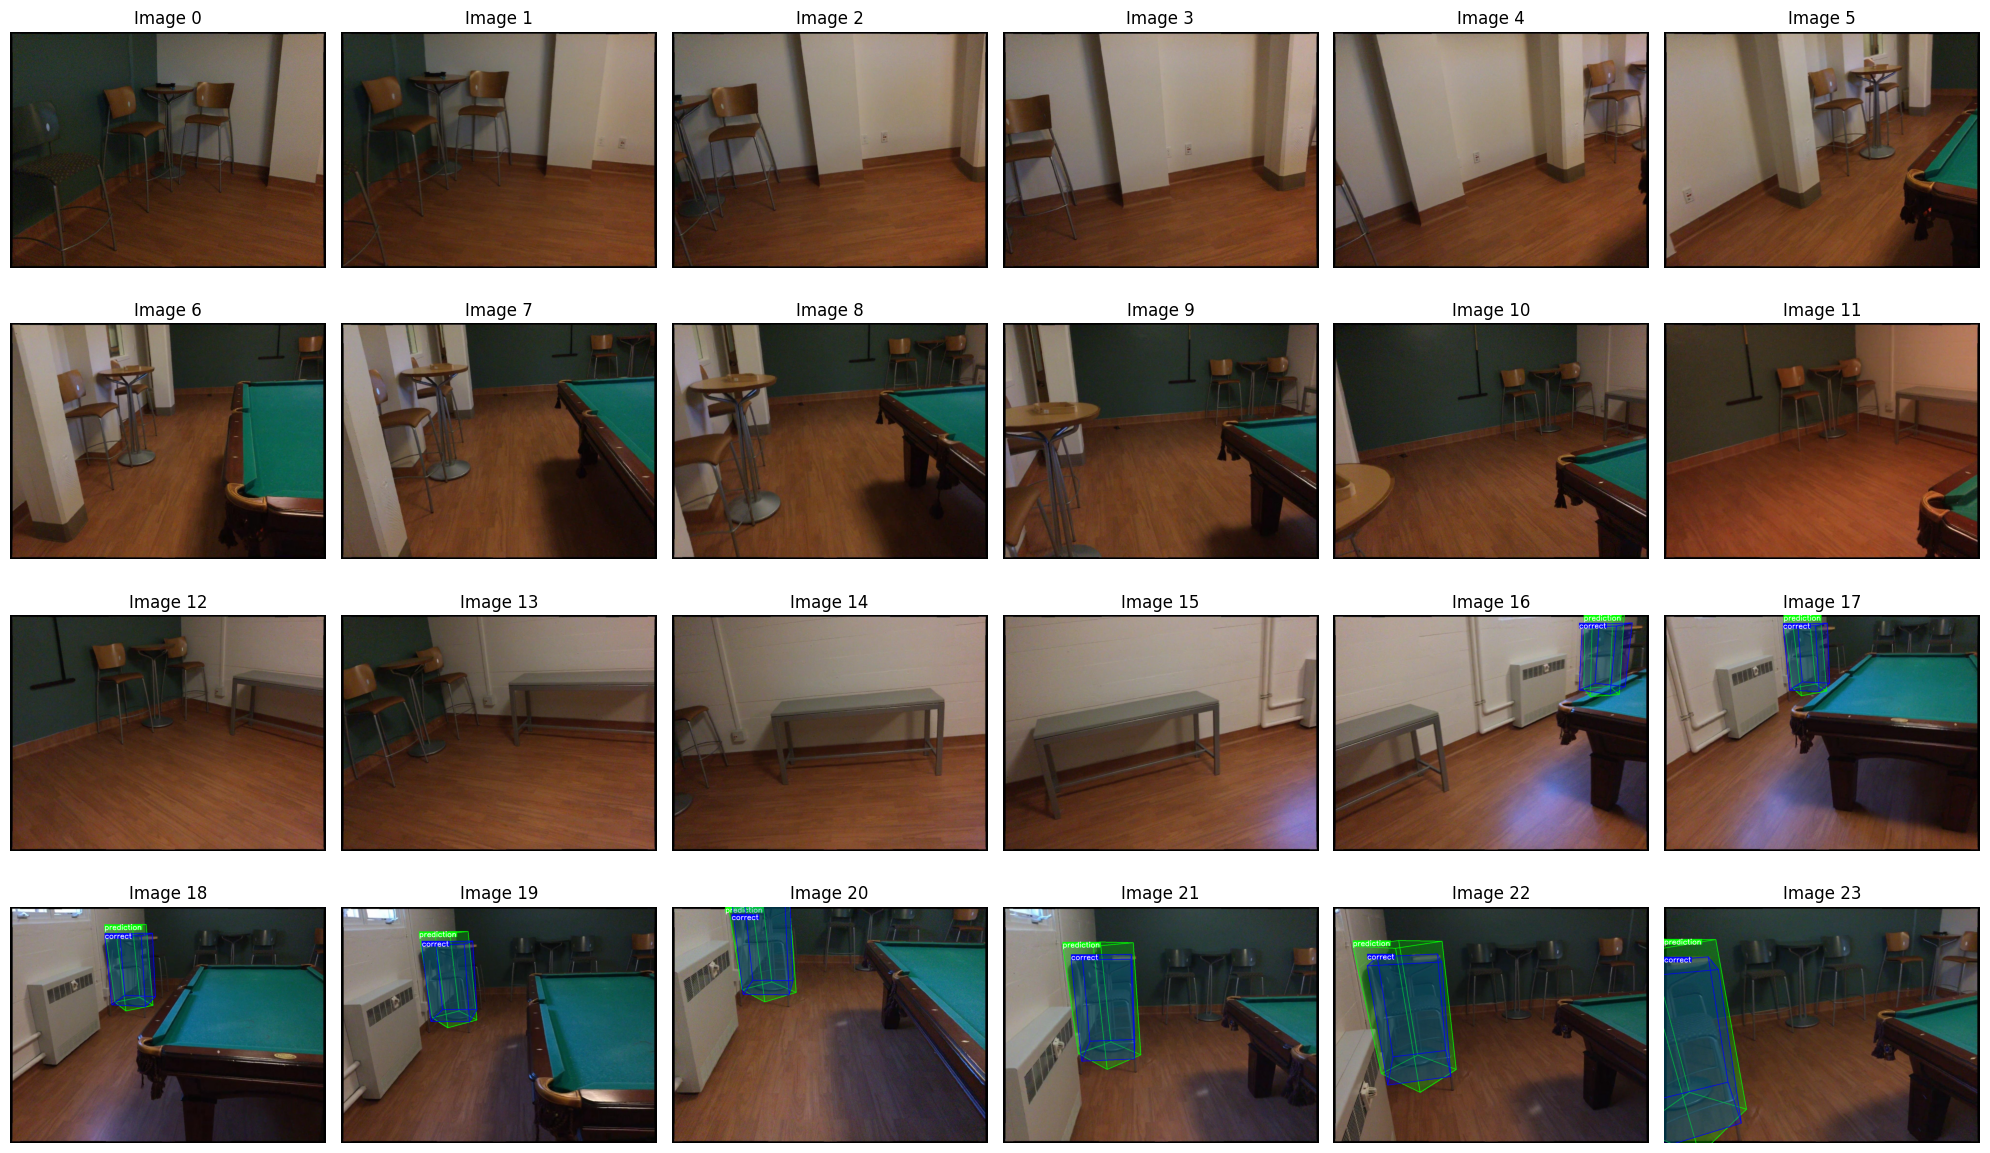

In [10]:
def process_3d_visual_grounding(sample):
    text = sample["prompt"]
    image_files = sample["images"]
    images = [
        Image.open(
            os.path.join(demo_data_dir, f"{task}/media", image_file)
        ).convert("RGB")
        for image_file in image_files
    ]

    output = model.call_model(
        contexts=[text],
        visuals=[images],
        add_frame_index=True,
    )[0]

    print("Query:", text.split("\n")[1])
    print("Output:", output)
    visualize_3d_visual_grounding(sample, output)

process_3d_visual_grounding(data[8])